In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from ast import literal_eval

import matplotlib.pyplot as plt

/home/tobias/.virtualenvs/pytorch/local/lib/python2.7/site-packages/matplotlib/__init__.py:907: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


# Dataset Introduction

In this short introduction you will see how the different csv data files are connected and can be combined in order to complete the following tasks:

- load metadata
- load transliterations
- download tablet images
- plot tablet segments
- plot bounding box annotations
- plot line annotations

In the following we will demonstrate these tasks on a single clay tablet from the dataset. So we first pick a collection and a tablet to work with.

## Pick a collection 
All clay tablets in this dataset are organized in collections. Except for the train and test set we follow the collection structure of SAA.

In [2]:
selected_collection = 'test'

In [3]:
# read csv file
seg_df = pd.read_csv('./segments/tablet_segments_{}.csv'.format(selected_collection))
# convert bbox to np array
seg_df.bbox = seg_df.bbox.apply(literal_eval).apply(np.array)
# remove unassigned segments
seg_df = seg_df[seg_df.assigned]
# show first few entries
seg_df

,segm_idx,tablet_CDLI,view_desc,collection,bbox,scale,assigned
0,0,ND02486,Rev,test,"[391, 1734, 1201, 2825]",1.41,True
1,1,ND02486,Obv,test,"[382, 343, 1196, 1431]",1.63,True
7,7,K08396,Rev,test,"[433, 1312, 1384, 2304]",3.60,True
8,8,K08396,Obv,test,"[406, 83, 1360, 1046]",3.60,True
11,11,BM099070,Obv,test,"[523, 362, 1500, 1326]",1.87,True
16,16,P334926,Obv,test,"[374, 61, 1260, 1022]",3.23,True
17,17,P334926,Rev,test,"[397, 1320, 1259, 2284]",3.23,True
18,18,P334932,Obv,test,"[276, 1260, 1345, 2103]",2.57,True
19,19,P334932,Rev,test,"[285, 2992, 1341, 3836]",2.57,True
20,20,P336128,Obv,test,"[374, 52, 1474, 831]",2.59,True


## Pick a tablet
Attention: for a couple of tablets in the train and test collection we used the accession no. instead of the cdli no.

In [4]:
selected_cdli = 'P334926'

# select slice from dataframe
seg_df_slice = seg_df[seg_df.tablet_CDLI.isin([selected_cdli])]
seg_df_slice

,segm_idx,tablet_CDLI,view_desc,collection,bbox,scale,assigned
16,16,P334926,Obv,test,"[374, 61, 1260, 1022]",3.23,True
17,17,P334926,Rev,test,"[397, 1320, 1259, 2284]",3.23,True


For this tablet there are two segments. While some tablets often have more available views, we assigned at most the obverse and reverse views. 

Individual segments can be uniquely identified by their tablet_CDLI together with the segm_idx columns. For these two segments their indices are 16 and 17.

In [5]:
seg_df_slice.segm_idx

16    16
17    17
Name: segm_idx, dtype: int64

## Load corresponding transliteration
Given the collection and tablet, we load the corresponding transliteration.

In [6]:
# load transliterations of collection
tl_df = pd.read_csv('./transliterations/transliterations_{}.csv'.format(selected_collection))

The *tablet_CDLI* and *segm_idx* columns serve as unique selection key.

In [7]:
tl_df = tl_df.set_index(['tablet_CDLI', 'segm_idx']).sort_index()

For each segment we display the first view rows of the transliteration. 

In [8]:
for i, s_rec in seg_df_slice.iterrows():
    print(s_rec.tablet_CDLI, s_rec.view_desc)
    display(tl_df.loc[(selected_cdli, s_rec.segm_idx)].head())

('P334926', 'Obv')


view_desc  rec_idx  line_idx  pos_idx  train_label  \
tablet_CDLI segm_idx                                                      
P334926     16             Obv        0         0        0           30   
            16             Obv        1         0        1            4   
            16             Obv        2         0        2          103   
            16             Obv        3         0        3          183   
            16             Obv        4         0        4           14   

                      mzl_label  status  
tablet_CDLI segm_idx                     
P334926     16              490       1  
            16              110       1  
            16              635       1  
            16              258       1  
            16              748       1

('P334926', 'Rev')


view_desc  rec_idx  line_idx  pos_idx  train_label  \
tablet_CDLI segm_idx                                                      
P334926     17             Rev        0         0        0            2   
            17             Rev        1         0        1          158   
            17             Rev        2         0        2          193   
            17             Rev        3         0        3            1   
            17             Rev        4         0        4           30   

                      mzl_label  status  
tablet_CDLI segm_idx                     
P334926     17                1       1  
            17              485       1  
            17               71       1  
            17              859       1  
            17              490       1

The *record index* (rec_idx) identifies the  entry position inside the transliteration of the segment. The *line index* (line_idx) identifies the line inside the segment and the *position index* (pos_idx) identifies the sign inside the line.

## Load corresponding bounding box annotations

We will load the annotations and display them in the images. 

Since *test* collection is part of *test_full*, we will load the *test_full* bounding box annotations.

In [9]:
# load bbox annoations of collection
anno_df = pd.read_csv('./annotations/bbox_annotations_{}_full.csv'.format(selected_collection))
# convert bbox and relative bbox to np array
anno_df.relative_bbox = anno_df.relative_bbox.apply(literal_eval).apply(np.array)

In [10]:
# select slice of the dataset corresponding to entries of the selected cdli
anno_df_slice = anno_df[anno_df.tablet_CDLI == selected_cdli]
anno_df_slice.head()

,segm_idx,tablet_CDLI,view_desc,collection,mzl_label,train_label,bbox,relative_bbox
116,17,P334926,Rev,test,490,30,"[735, 1393, 818, 1431]","[338, 73, 421, 111]"
117,17,P334926,Rev,test,567,96,"[811, 1388, 876, 1429]","[414, 68, 479, 109]"
118,17,P334926,Rev,test,71,193,"[612, 1405, 693, 1446]","[215, 85, 296, 126]"
119,17,P334926,Rev,test,859,1,"[689, 1399, 741, 1443]","[292, 79, 344, 123]"
120,17,P334926,Rev,test,583,234,"[855, 1381, 964, 1429]","[458, 61, 567, 109]"


We can easily check, how many annotations are available for the two segments of the tablet.

In [11]:
anno_df_slice['view_desc'].value_counts()

Obv    175
Rev     27
Name: view_desc, dtype: int64

## Load the composite image from CDLI

Now we load the image from the CDLI webpage and store it for further processing.

In [12]:
import urllib2

Using the cdli number we can generate an link to the image. You open it in the browser to verify it works.

In [13]:
# define url
url_template = 'https://cdli.ucla.edu/dl/photo/{}.jpg'
image_url = url_template.format(selected_cdli)
print(image_url)

https://cdli.ucla.edu/dl/photo/P334926.jpg


In [14]:
# load image
im = Image.open(urllib2.urlopen(image_url))

In [15]:
# store image
im.save('./images/{}/{}.jpg'.format(selected_collection, selected_cdli))

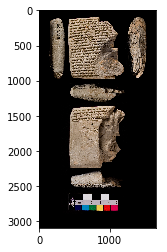

In [16]:
# plot image
plt.imshow(np.asarray(im))
plt.show()

## Visualize segments

First we visualize the tablet segments by cropping them from the composite image that is available at the CDLI webpage.

In [17]:
def crop_segment_from_image(im, bb):
    """
    im: pil image
    bb: list of segment bounding box coordinates as xmin, ymin, xmax, ymax.
    return: cropped segment as pil image
    """
    return im.crop((bb[0], bb[1], bb[2], bb[3]))

The segments are defined in terms of bounding boxes in the composite image.

Bounding boxes are rectangles that are defined by two extreme points in the format [xmin, ymin, xmax, ymax]. These two points describe the endpoints of a diagonal of the rectangle.

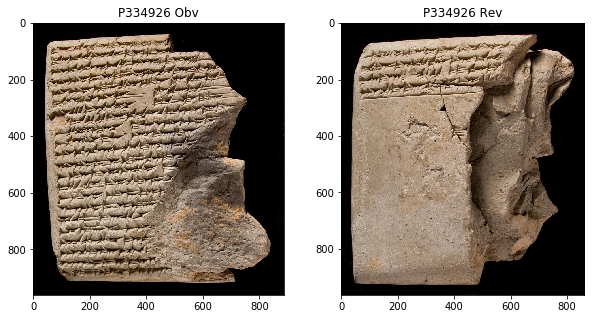

In [18]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
for i, (si, s_rec) in enumerate(seg_df_slice.iterrows()):
    path_to_image = './images/test/{}.jpg'.format(s_rec.tablet_CDLI)
    # open tablet image
    pil_im = Image.open(path_to_image)
    # crop segment
    tablet_seg = crop_segment_from_image(pil_im, s_rec.bbox)
    # plot segment
    ax[i].imshow(np.asarray(tablet_seg))
    ax[i].set_title("{} {}".format(s_rec.tablet_CDLI, s_rec.view_desc))
plt.show()

## Visualize bounding box annotations

Now lets plot the bounding boxes. For each annotation there is a bbox and a relative bbox available. The coordinates of the relative bbox describe the position of the bbox in the cropped segment.

In [19]:
def plot_boxes(boxes, labels, ax=None):
    # setup figure if necessary
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 12))
    # iterate over bounding boxes
    for ii, bbox in enumerate(boxes):
        # plot box
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], 
                          fill=False, edgecolor='blue', alpha=0.8, linewidth=2.0)) 
        # plot label
        ax.text(bbox[0], bbox[1] - 2, '{}'.format(labels[ii]),
                      bbox=dict(facecolor='blue', alpha=0.4), fontsize=8, color='white')

Signs are defined in terms of bounding boxes in the tablet image. Similar to the bounding boxes that describe a segment bounding boxes are rectangles that are defined by two extreme points in the format [xmin, ymin, xmax, ymax]. 

Each bounding box annotation comes with a label indicating the sign class. the mzl_label follows the convention estabilished in Borger's "Mesopotamisches Zeichenlexikon (MZL)". The other label is used for training the sign detector. There is a bijective mapping between the two labelings that is provided in the labels.json file.



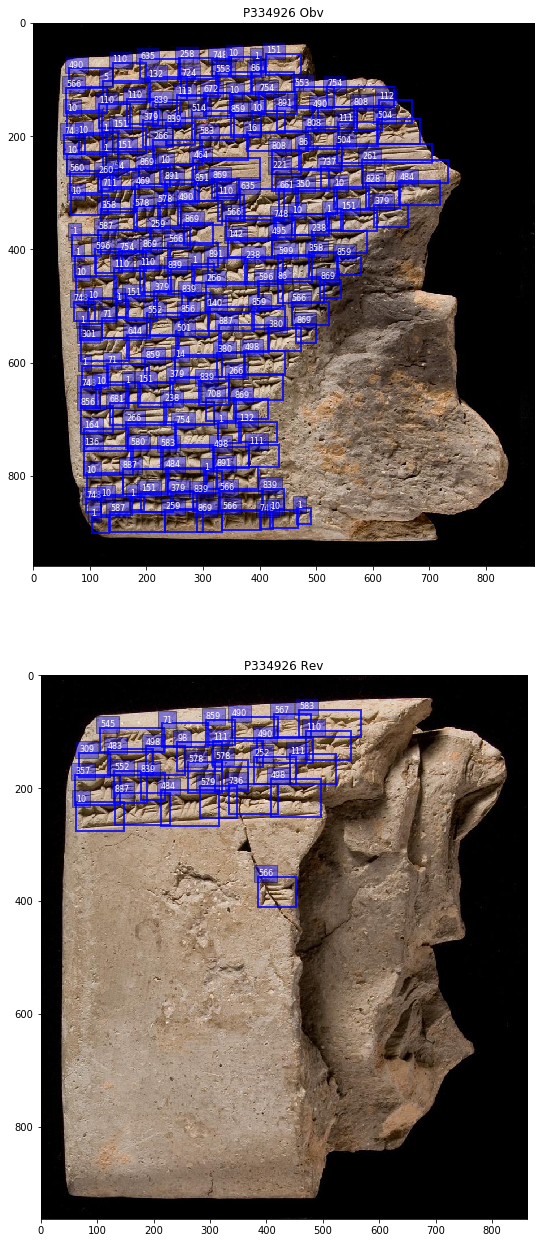

In [20]:
fig, ax = plt.subplots(2,1, figsize=(18, 22))
for i, (si, s_rec) in enumerate(seg_df_slice.iterrows()):
    path_to_image = './images/test/{}.jpg'.format(s_rec.tablet_CDLI)
    # open tablet image
    pil_im = Image.open(path_to_image)
    # crop segment
    tablet_seg = crop_segment_from_image(pil_im, s_rec.bbox)
    # plot segment
    ax[i].imshow(np.asarray(tablet_seg))
    ax[i].set_title("{} {}".format(s_rec.tablet_CDLI, s_rec.view_desc))
    
    # select annotations
    selected_segm = (anno_df_slice.segm_idx == s_rec.segm_idx)
    sign_bboxes = np.stack(anno_df_slice[selected_segm].relative_bbox.values)
    sign_lbls = anno_df_slice[selected_segm].mzl_label.values
    
    # plot boxes
    plot_boxes(sign_bboxes, sign_lbls, ax=ax[i])
plt.show()

## Load line annotations

There are only line annotations available for train and test collections. 

We will load the line annotations corresponding to the tablet we selected above.

In [21]:
line_df = pd.read_csv('./annotations/line_annotations_{}.csv'.format(selected_collection))
line_df.head()

,line_idx,x,y,segm_idx
0,0,128,175,0
1,0,307,155,0
2,0,596,162,0
3,1,307,81,0
4,1,448,78,0


Annotated lines consist of one or several connected segments that are defined by the start or end points of segments. The *line index (line_idx)* identifies the points belonging to a line. The points are sorted by their x coordinate from left to right. 

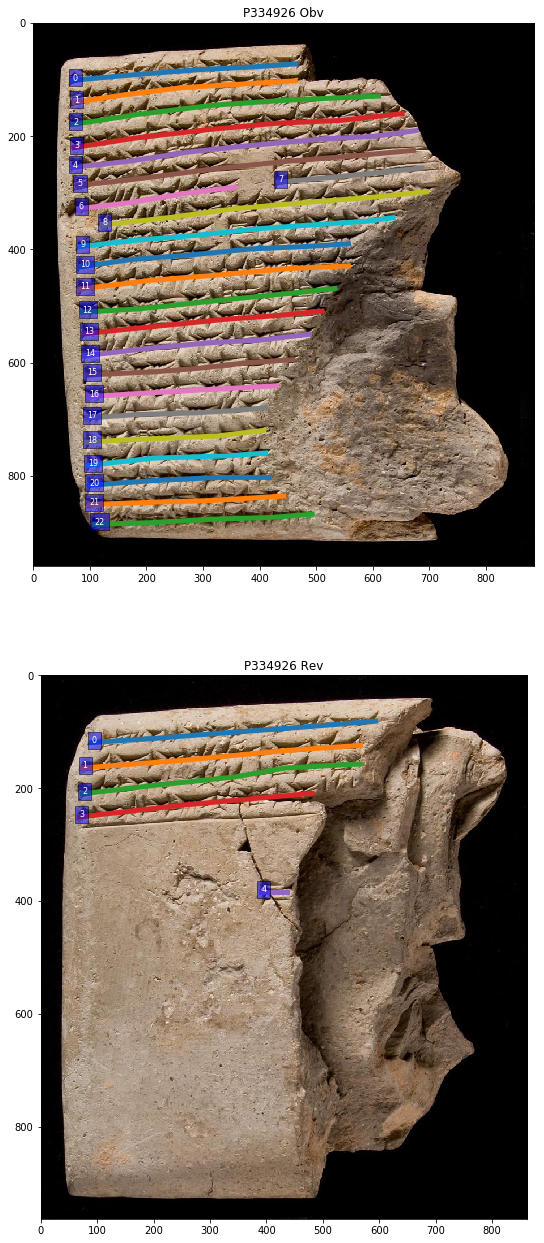

In [22]:
fig, ax = plt.subplots(2,1, figsize=(18, 22))
for i, (si, s_rec) in enumerate(seg_df_slice.iterrows()):
    path_to_image = './images/test/{}.jpg'.format(s_rec.tablet_CDLI)
    # open tablet image
    pil_im = Image.open(path_to_image)
    # crop segment
    tablet_seg = crop_segment_from_image(pil_im, s_rec.bbox)

    # select line annotations
    line_df_slice = line_df[line_df.segm_idx == s_rec.segm_idx]

    # plot line annotations
    grouped = line_df_slice.groupby('line_idx')
    for li, line_rec in grouped:
        # plot single line as piece-wise linear function
        ax[i].plot(line_rec.x.values, line_rec.y.values, linewidth=5)
        # annotated line with line index
        ax[i].text(line_rec.x.values[0], line_rec.y.values[0], 
                   '{}'.format(line_rec.line_idx.values[0]),
                   bbox=dict(facecolor='blue', alpha=0.5), fontsize=8, color='white')  
    # plot image
    ax[i].imshow(np.asarray(tablet_seg), cmap='gray')
    ax[i].set_title("{} {}".format(s_rec.tablet_CDLI, s_rec.view_desc))
plt.show()